In [ ]:
import pandas as pd

df = pd.read_csv('versionInfo.csv')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 12 columns):
 #   Column                                        Non-Null Count  Dtype 
---  ------                                        --------------  ----- 
 0   filename                                      8 non-null      object
 1   version                                       8 non-null      object
 2   url                                           8 non-null      object
 3   description                                   8 non-null      object
 4   Type                                          8 non-null      object
 5   Associations with external schemes            8 non-null      object
 6   Available associations with external schemes  5 non-null      object
 7   Presence of controls/metrics                  8 non-null      object
 8   Number of controls/metrics                    8 non-null      int64 
 9   Association with old data                     3 non-null      object
 10  Associ

In [ ]:
# Lista delle colonne da mantenere
cols_to_keep = [
    'filename',
    'Type',
    'Available associations with external schemes',
    'Number of controls/metrics',
    'Association with old data',
    'Association with new data'
]

# Crea il nuovo dataframe filtrato
df = df[cols_to_keep]


df

,filename,Type,Available associations with external schemes,Number of controls/metrics,Association with old data,Association with new data
0,Cisco.csv,Controls,"SpanishENS.csv, NewEucsRequirements.csv, Secnu...",713,NaN,"SpanishENS.csv, NewEucsRequirements.csv, Secnu..."
1,SpanishENS.csv,Controls,NaN,209,NaN,NaN
2,BSI-C5.json,Controls,OldEucsRequirements.csv,294,OldEucsRequirements.csv,NaN
3,Secnumcloud.csv,Controls,NaN,287,NaN,NaN
4,medinaMetrics.csv,Metrics,OldEucsRequirements.csv,166,OldEucsRequirements.csv,NaN
5,fabasoftMetrics.csv,Metrics,"OldEucsRequirements.csv, BSI-C5.json",57,NaN,"NewEucsRequirements.csv, BSI-C5.json"
6,NewEucsRequirements_with_texts.csv,Controls,"BSI-C5.json, Secnumcloud.csv\n",120,BSI-C5.json,Secnumcloud.csv\nBSI-C5.json
7,OldEucsRequirements.csv,Controls,NaN,70,NaN,NaN


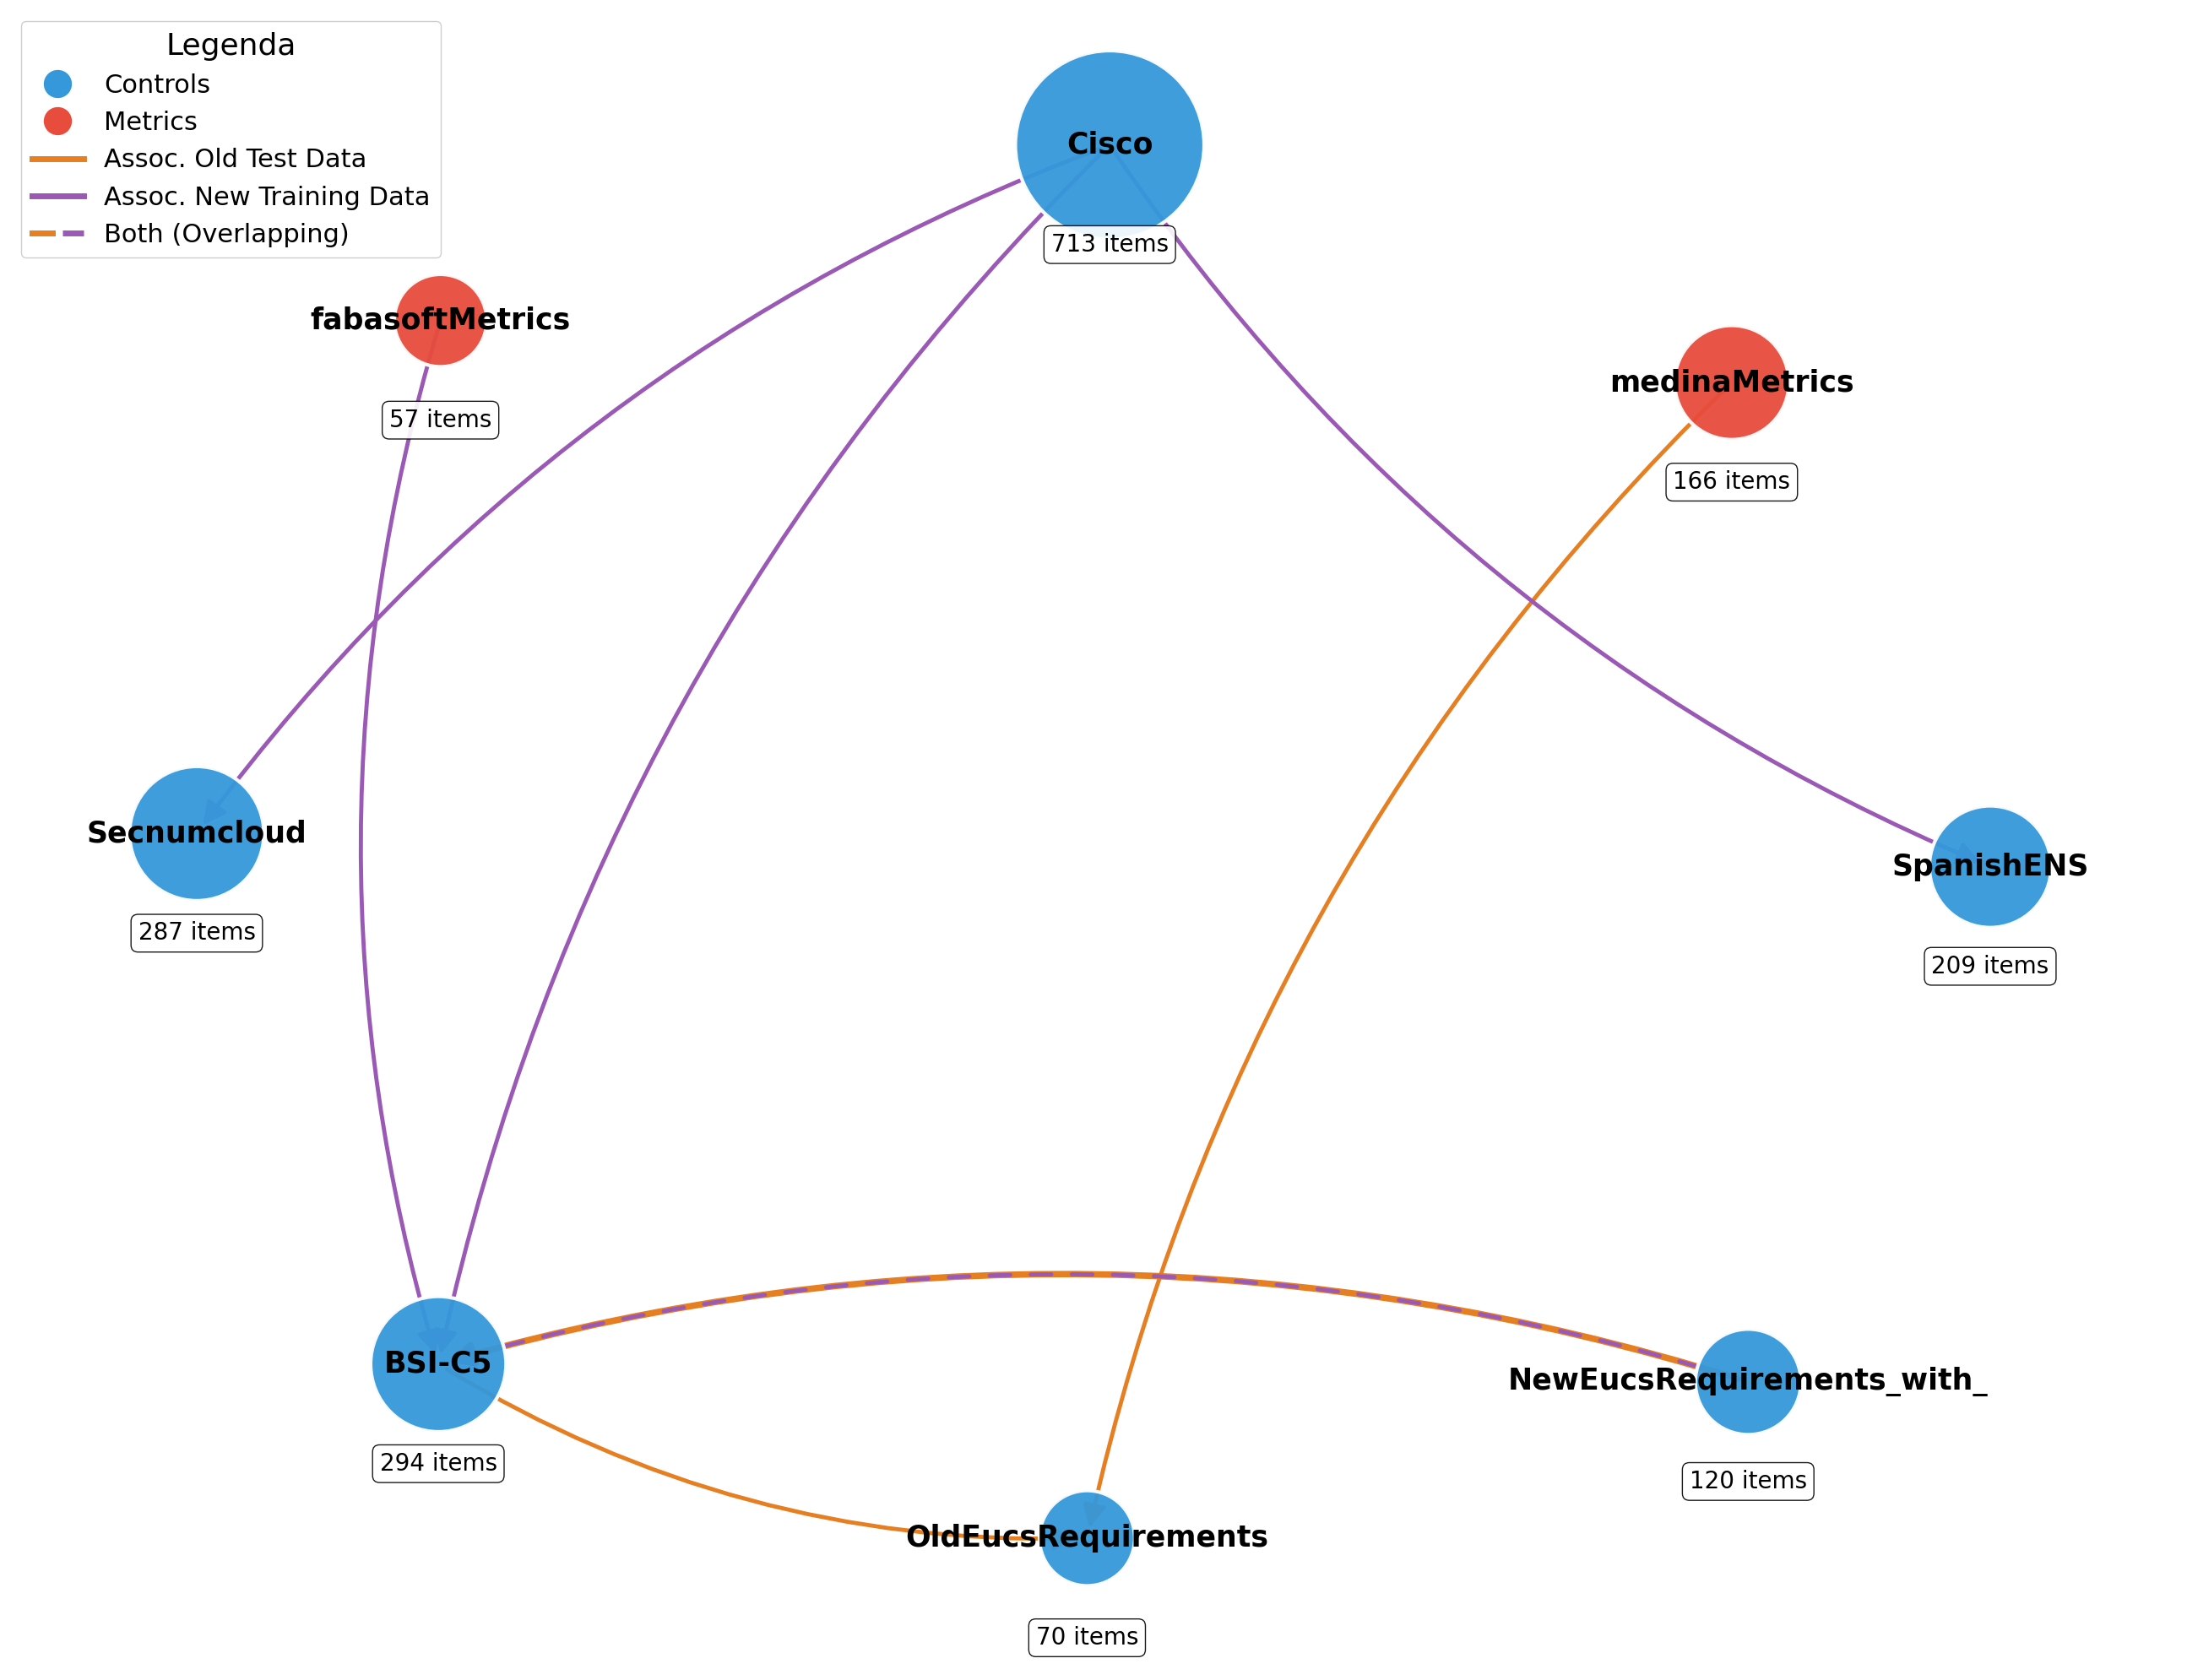

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import numpy as np
from matplotlib.lines import Line2D

# Assumiamo che il tuo dataframe si chiami 'df'
df = df.fillna('')

G = nx.DiGraph()

# 1. AGGIUNTA DEI NODI
for idx, row in df.iterrows():
    filename = row['filename']
    node_type = row['Type']
    try:
        n_controls = int(row['Number of controls/metrics']) if row['Number of controls/metrics'] != '' else 10
    except:
        n_controls = 10
    
    G.add_node(filename, type=node_type, n_controls=n_controls)

# 2. AGGIUNTA DEGLI ARCHI CON CLASSIFICAZIONE
COLOR_OLD = '#e67e22' # Arancio
COLOR_NEW = '#9b59b6' # Viola

def add_edges_from_column(graph, dataframe, source_node, column_name, category_tag):
    associations = dataframe.loc[dataframe['filename'] == source_node, column_name].values[0]
    
    if associations and str(associations).lower() != 'nan':
        target_list = [t.strip() for t in str(associations).split(',')]
        for target_partial_name in target_list:
            if not target_partial_name: continue
            
            # Fuzzy match
            matched_target = None
            for candidate in dataframe['filename']:
                if target_partial_name in candidate or candidate in target_partial_name:
                    matched_target = candidate
                    break
            
            if matched_target:
                # Logica "Both"
                if graph.has_edge(source_node, matched_target):
                    current_tag = graph[source_node][matched_target].get('tag')
                    if current_tag != category_tag:
                        graph[source_node][matched_target]['tag'] = 'both'
                else:
                    graph.add_edge(source_node, matched_target, tag=category_tag)

# Aggiungiamo gli archi
for idx, row in df.iterrows():
    source = row['filename']
    add_edges_from_column(G, df, source, 'Association with old data', 'old')
    add_edges_from_column(G, df, source, 'Association with new data', 'new')

# 3. CONFIGURAZIONE VISUALIZZAZIONE
fig, ax = plt.subplots(figsize=(26, 20)) 

pos = nx.spring_layout(G, k=10, iterations=100, seed=42)

color_map_nodes = {
    'Controls': '#3498db',
    'Metrics': '#e74c3c',
    'Requirements': '#2ecc71',
}
node_colors = [color_map_nodes.get(G.nodes[node].get('type', 'Other'), '#95a5a6') for node in G.nodes()]

# Dimensioni Nodi (Base 4500 per testo grande)
node_sizes = [G.nodes[node]['n_controls'] * 30 + 4500 for node in G.nodes()]

# --- DISEGNO DEGLI ARCHI ---

edges_old = [(u, v) for u, v, d in G.edges(data=True) if d.get('tag') == 'old']
edges_new = [(u, v) for u, v, d in G.edges(data=True) if d.get('tag') == 'new']
edges_both = [(u, v) for u, v, d in G.edges(data=True) if d.get('tag') == 'both']

arrow_style = '-|>'
arrow_size = 40
conn_style = 'arc3,rad=0.15'
line_width = 3.5

# 1. Disegna Old (Arancio)
nx.draw_networkx_edges(G, pos, edgelist=edges_old, edge_color=COLOR_OLD, 
                       arrows=True, arrowsize=arrow_size, arrowstyle=arrow_style, 
                       width=line_width, connectionstyle=conn_style, ax=ax)

# 2. Disegna New (Viola)
nx.draw_networkx_edges(G, pos, edgelist=edges_new, edge_color=COLOR_NEW, 
                       arrows=True, arrowsize=arrow_size, arrowstyle=arrow_style, 
                       width=line_width, connectionstyle=conn_style, ax=ax)

# 3. Disegna BOTH (Doppia Linea: Arancio sotto + Viola tratteggiato sopra)
# Layer Sotto (Arancio Solido)
nx.draw_networkx_edges(G, pos, edgelist=edges_both, edge_color=COLOR_OLD, 
                       arrows=True, arrowsize=arrow_size, arrowstyle=arrow_style, 
                       width=line_width+2, connectionstyle=conn_style, ax=ax)

# Layer Sopra (Viola Tratteggiato)
nx.draw_networkx_edges(G, pos, edgelist=edges_both, edge_color=COLOR_NEW, 
                       arrows=True, arrowsize=arrow_size, arrowstyle=arrow_style, 
                       width=line_width, connectionstyle=conn_style, style=(0, (5, 5)), ax=ax)

# --- DISEGNO NODI E TESTI ---

nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes, 
                       alpha=0.95, ax=ax, edgecolors='white', linewidths=3)

# Etichette (Font 35)
labels = {node: node.replace('.csv', '').replace('.json', '')[:25] for node in G.nodes()}
nx.draw_networkx_labels(G, pos, labels, font_size=25, font_weight='bold', ax=ax)

# Annotazioni sotto i nodi
for node, (x, y) in pos.items():
    info = G.nodes[node]
    text = f"{info['n_controls']} items"
    ax.text(x, y-0.15, text, fontsize=20, ha='center', 
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.9))

# 4. LEGENDA CORRETTA CON EFFETTO BICOLORE REALE
from matplotlib.lines import Line2D

# Definiamo i nodi
legend_nodes = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='#3498db', markersize=25, label='Controls'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='#e74c3c', markersize=25, label='Metrics'),
]

# Definiamo le linee base
line_old = Line2D([0], [0], color=COLOR_OLD, lw=5, label='Assoc. Old Data')
line_new = Line2D([0], [0], color=COLOR_NEW, lw=5, label='Assoc. New Data')

# --- IL TRUCCO PER LA LEGENDA BICOLORE ---
# Creiamo due linee "fittizie" senza etichetta per comporre l'icona "Both"
# 1. La base arancione solida
line_both_base = Line2D([0], [0], color=COLOR_OLD, lw=5)
# 2. La copertura viola tratteggiata (uguale a quella usata nel grafico)
line_both_dash = Line2D([0], [0], color=COLOR_NEW, lw=5, linestyle=(0, (5, 5)))

# Componiamo la lista degli handles.
# Nota la TUPLA (line_both_base, line_both_dash): sovrappone le due linee nella legenda
legend_handles = [
    legend_nodes[0], 
    legend_nodes[1],
    line_old, 
    line_new, 
    (line_both_base, line_both_dash) # <--- Qui avviene la magia
]

# Definiamo le etichette corrispondenti
legend_labels = [
    'Controls', 
    'Metrics', 
    'Assoc. Old Test Data', 
    'Assoc. New Training Data', 
    'Both (Overlapping)'
]

ax.legend(handles=legend_handles, labels=legend_labels, loc='upper left', 
          fontsize=22, title_fontsize=26, framealpha=0.95, title="Legenda",
          handler_map={tuple: plt.matplotlib.legend_handler.HandlerTuple(ndivide=None)})

ax.axis('off')
plt.tight_layout()
plt.show()

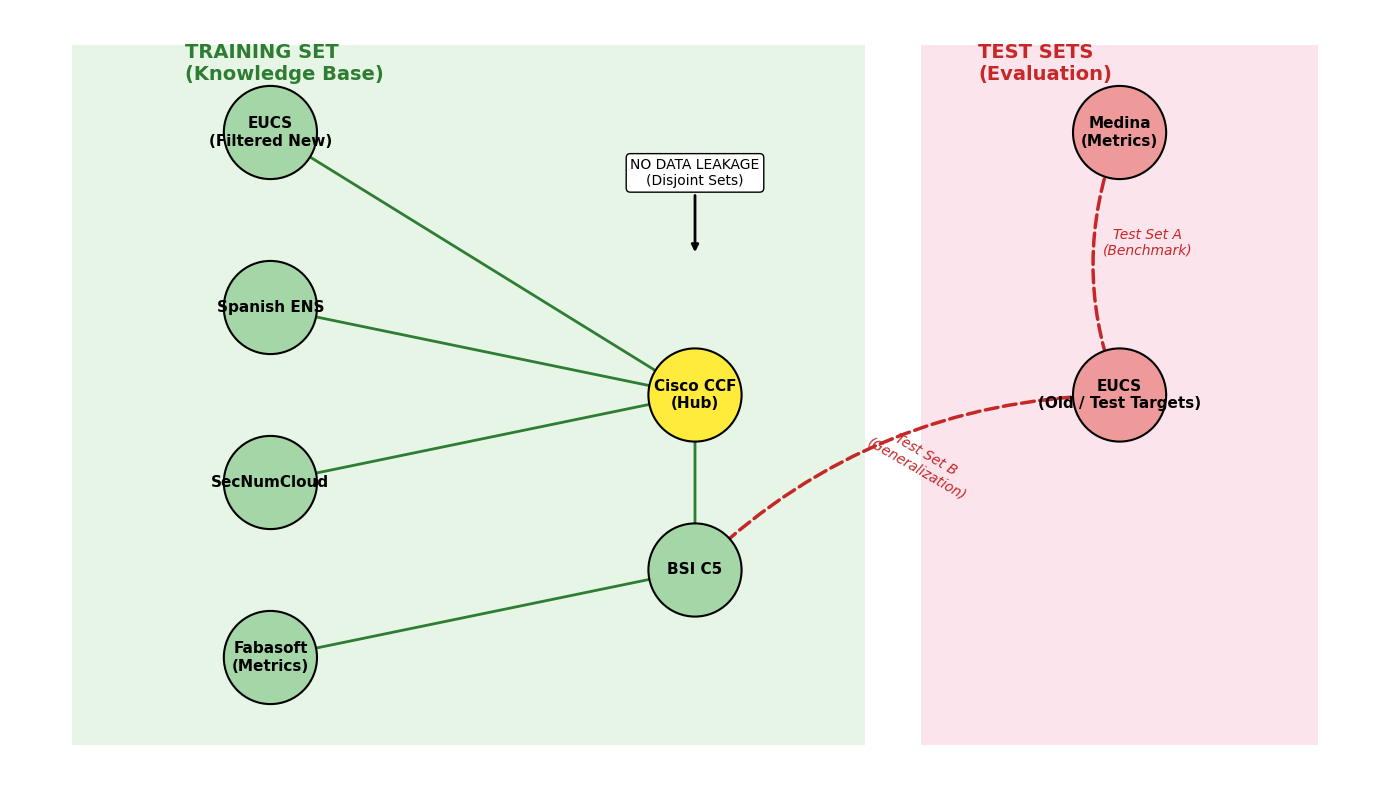

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib.patches as patches

def draw_publication_graph():
    # Creazione del grafo diretto
    G = nx.DiGraph()

    # --- DEFINIZIONE NODI ---
    # Dividiamo i nodi in gruppi logici
    
    # HUB
    hub_node = "Cisco CCF\n(Hub)"
    
    # TRAINING SOURCES
    train_nodes = [
        "Spanish ENS", 
        "SecNumCloud", 
        "BSI C5",
        "Fabasoft\n(Metrics)",
        "EUCS\n(Filtered New)"
    ]
    
    # TEST SOURCES
    test_nodes = [
        "Medina\n(Metrics)",
        "EUCS\n(Old / Test Targets)"
    ]

    # Aggiungiamo i nodi al grafo
    G.add_node(hub_node, type='hub')
    for n in train_nodes: G.add_node(n, type='train')
    for n in test_nodes: G.add_node(n, type='test')

    # --- DEFINIZIONE ARCHI (LE RELAZIONI) ---
    # Training Flow (Solid lines)
    training_edges = [
        (hub_node, "Spanish ENS"),
        (hub_node, "SecNumCloud"),
        (hub_node, "BSI C5"),
        ("Fabasoft\n(Metrics)", "BSI C5"), # Il ponte Fabasoft -> BSI
        (hub_node, "EUCS\n(Filtered New)")
    ]
    
    # Test Flow (Dashed lines)
    test_edges = [
        ("Medina\n(Metrics)", "EUCS\n(Old / Test Targets)"), # Test Set A
        ("EUCS\n(Old / Test Targets)", "BSI C5")             # Test Set B (Generalization)
    ]

    # --- LAYOUT MANUALE (Per ordine perfetto) ---
    # Coordinate (x, y). 
    # Sinistra = Training, Centro = Hub/Standard Condivisi, Destra = Test
    pos = {
        # Centro
        hub_node: (0, 0),
        "BSI C5": (0, -1),  # BSI è condiviso come concetto, ma usato nel training via Cisco
        
        # Sinistra (Training Puro)
        "Spanish ENS": (-1.5, 0.5),
        "SecNumCloud": (-1.5, -0.5),
        "EUCS\n(Filtered New)": (-1.5, 1.5),
        "Fabasoft\n(Metrics)": (-1.5, -1.5),
        
        # Destra (Testing Puro)
        "EUCS\n(Old / Test Targets)": (1.5, 0),
        "Medina\n(Metrics)": (1.5, 1.5),
    }

    # --- DISEGNO ---
    plt.figure(figsize=(14, 8))
    ax = plt.gca()
    
    # 1. Disegna le aree di sfondo (Training Zone vs Test Zone)
    # Area Training (Verde chiaro)
    rect_train = patches.Rectangle((-2.2, -2.0), 2.8, 4.0, linewidth=0, edgecolor='none', facecolor='#e6f5e6', zorder=0)
    ax.add_patch(rect_train)
    plt.text(-1.8, 1.8, "TRAINING SET\n(Knowledge Base)", fontsize=14, fontweight='bold', color='#2e7d32', zorder=1)

    # Area Testing (Rosso chiaro)
    rect_test = patches.Rectangle((0.8, -2.0), 1.4, 4.0, linewidth=0, edgecolor='none', facecolor='#fce4ec', zorder=0)
    ax.add_patch(rect_test)
    plt.text(1.0, 1.8, "TEST SETS\n(Evaluation)", fontsize=14, fontweight='bold', color='#c62828', zorder=1)

    # 2. Disegna i nodi
    # Stile nodi
    node_colors = []
    for node in G.nodes():
        if node == hub_node:
            node_colors.append('#ffeb3b') # Giallo per Hub
        elif node in train_nodes:
            node_colors.append('#a5d6a7') # Verde per Training
        else:
            node_colors.append('#ef9a9a') # Rosso per Test
            
    nx.draw_networkx_nodes(G, pos, node_size=4500, node_color=node_colors, edgecolors='black', linewidths=1.5)
    
    # 3. Disegna le etichette
    nx.draw_networkx_labels(G, pos, font_size=11, font_weight='bold')

    # 4. Disegna gli archi
    # Training (Solidi)
    nx.draw_networkx_edges(G, pos, edgelist=training_edges, edge_color='#2e7d32', width=2, arrows=True, arrowstyle='-|>')
    # Test (Tratteggiati) - Li facciamo curvi per distinguerli
    nx.draw_networkx_edges(G, pos, edgelist=test_edges, edge_color='#c62828', width=2.5, style='dashed', 
                           arrows=True, arrowstyle='-|>', connectionstyle="arc3,rad=0.2")

    # 5. Annotazioni speciali
    # Annotazione per il NO LEAKAGE
    plt.annotate("NO DATA LEAKAGE\n(Disjoint Sets)", 
                 xy=(0, 0.8), xytext=(0, 1.2),
                 arrowprops=dict(arrowstyle="-|>", color='black', lw=2),
                 bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=1),
                 ha='center', fontsize=10)

    # Annotazione Test Set A
    plt.text(1.6, 0.8, "Test Set A\n(Benchmark)", color='#c62828', fontsize=10, ha='center', style='italic')
    
    # Annotazione Test Set B
    plt.text(0.8, -0.6, "Test Set B\n(Generalization)", color='#c62828', fontsize=10, ha='center', style='italic', rotation=-30)

    plt.axis('off')
    plt.tight_layout()
    plt.savefig("paper_architecture_diagram.pdf", bbox_inches='tight') # Salva come PDF vettoriale per LaTeX
    plt.show()

draw_publication_graph()

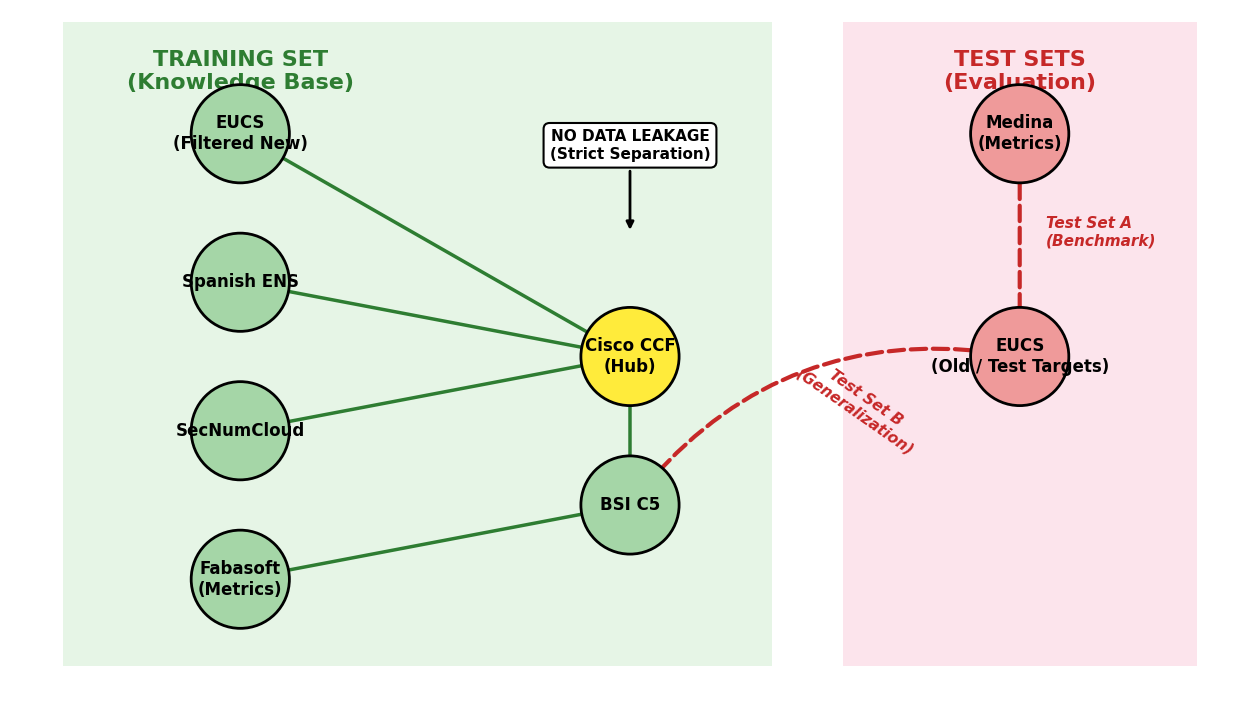

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib.patches as patches

def draw_improved_publication_graph():
    # Creazione del grafo diretto
    G = nx.DiGraph()

    # --- DEFINIZIONE NODI ---
    hub_node = "Cisco CCF\n(Hub)"
    
    train_nodes = [
        "Spanish ENS", 
        "SecNumCloud", 
        "BSI C5",
        "Fabasoft\n(Metrics)",
        "EUCS\n(Filtered New)"
    ]
    
    test_nodes = [
        "Medina\n(Metrics)",
        "EUCS\n(Old / Test Targets)"
    ]

    G.add_node(hub_node)
    for n in train_nodes: G.add_node(n)
    for n in test_nodes: G.add_node(n)

    # --- DEFINIZIONE ARCHI ---
    training_edges = [
        (hub_node, "Spanish ENS"),
        (hub_node, "SecNumCloud"),
        (hub_node, "BSI C5"),
        ("Fabasoft\n(Metrics)", "BSI C5"),
        (hub_node, "EUCS\n(Filtered New)")
    ]
    
    test_edges = [
        ("Medina\n(Metrics)", "EUCS\n(Old / Test Targets)"), 
        ("EUCS\n(Old / Test Targets)", "BSI C5")
    ]

    # --- LAYOUT MIGLIORATO (Più largo) ---
    # Aumentiamo la X da 1.5 a 2.2 per dare respiro
    pos = {
        hub_node: (0, 0),
        "BSI C5": (0, -1.2),  # Spostato un po' più in basso
        
        # Lato Sinistro (Training)
        "Spanish ENS": (-2.2, 0.6),
        "SecNumCloud": (-2.2, -0.6),
        "EUCS\n(Filtered New)": (-2.2, 1.8),
        "Fabasoft\n(Metrics)": (-2.2, -1.8),
        
        # Lato Destro (Test)
        "EUCS\n(Old / Test Targets)": (2.2, 0),
        "Medina\n(Metrics)": (2.2, 1.8),
    }

    # --- DISEGNO ---
    plt.figure(figsize=(16, 9)) # Figura più larga
    ax = plt.gca()
    
    # 1. Sfondi (Resi più ampi per evitare tagli)
    # Area Training
    rect_train = patches.Rectangle((-3.2, -2.5), 4.0, 5.2, linewidth=0, edgecolor='none', facecolor='#e6f5e6', zorder=0)
    ax.add_patch(rect_train)
    plt.text(-2.2, 2.3, "TRAINING SET\n(Knowledge Base)", fontsize=16, fontweight='bold', color='#2e7d32', ha='center', va='center', zorder=1)

    # Area Testing
    rect_test = patches.Rectangle((1.2, -2.5), 2.0, 5.2, linewidth=0, edgecolor='none', facecolor='#fce4ec', zorder=0)
    ax.add_patch(rect_test)
    plt.text(2.2, 2.3, "TEST SETS\n(Evaluation)", fontsize=16, fontweight='bold', color='#c62828', ha='center', va='center', zorder=1)

    # 2. Disegno Nodi
    node_colors = []
    for node in G.nodes():
        if node == hub_node: node_colors.append('#ffeb3b')
        elif node in train_nodes: node_colors.append('#a5d6a7')
        else: node_colors.append('#ef9a9a')
            
    nx.draw_networkx_nodes(G, pos, node_size=5000, node_color=node_colors, edgecolors='black', linewidths=2)
    nx.draw_networkx_labels(G, pos, font_size=12, font_weight='bold')

    # 3. Disegno Archi
    nx.draw_networkx_edges(G, pos, edgelist=training_edges, edge_color='#2e7d32', width=2.5, arrowstyle='-|>')
    
    # Archi Test (Tratteggiati e Curvi)
    # Arco A (Dritto)
    nx.draw_networkx_edges(G, pos, edgelist=[test_edges[0]], edge_color='#c62828', width=3, style='dashed', arrowstyle='-|>', min_source_margin=20, min_target_margin=20)
    # Arco B (Curvo per aggirare l'Hub)
    nx.draw_networkx_edges(G, pos, edgelist=[test_edges[1]], edge_color='#c62828', width=3, style='dashed', 
                           connectionstyle="arc3,rad=0.3", arrowstyle='-|>', min_source_margin=20, min_target_margin=20)

    # 4. Annotazioni (Posizionate con cura)
    
    # NO LEAKAGE (Centrale alto)
    plt.annotate("NO DATA LEAKAGE\n(Strict Separation)", 
                 xy=(0, 1.0), xytext=(0, 1.6),
                 arrowprops=dict(arrowstyle="-|>", color='black', lw=2),
                 bbox=dict(boxstyle="round,pad=0.4", fc="white", ec="black", lw=1.5),
                 ha='center', fontsize=11, weight='bold', zorder=10)

    # Label Test Set A
    plt.text(2.35, 0.9, "Test Set A\n(Benchmark)", color='#c62828', fontsize=11, ha='left', style='italic', weight='bold')
    
    # Label Test Set B
    plt.text(1.3, -0.8, "Test Set B\n(Generalization)", color='#c62828', fontsize=11, ha='center', style='italic', weight='bold', rotation=-35)

    # --- FORZATURA MARGINI ---
    # Questo impedisce il taglio dei bordi
    ax.set_xlim(-3.5, 3.5)
    ax.set_ylim(-2.8, 2.8)
    
    plt.axis('off')
    
    # Salva con margini minimi extra per sicurezza
    plt.savefig("paper_architecture_v2.pdf", bbox_inches='tight', pad_inches=0.1)
    plt.show()

draw_improved_publication_graph()

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib.patches as patches

# 1. CONFIGURAZIONE BACKEND LATEX E FONT
matplotlib.use("pgf")

plt.rcParams.update({
    "pgf.texsystem": "pdflatex",
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": [],
    "axes.labelsize": 16,
    "font.size": 12,          # Font leggermente più piccolo per stare nei nodi
    "legend.fontsize": 12,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "pgf.rcfonts": False,
})

def draw_final_paper_graph():
    # Creazione del grafo diretto
    G = nx.DiGraph()

    # --- DEFINIZIONE NODI ---
    # Nota: Con LaTeX attivo, \n funziona, ma per il grassetto usiamo la logica di plot
    hub_node = "Cisco CCF\n(Hub)"
    
    train_nodes = [
        "Spanish ENS", 
        "SecNumCloud", 
        "BSI C5",
        "Fabasoft\n(Metrics)",
        "EUCS\n(Filtered New)"
    ]
    
    test_nodes = [
        "Medina\n(Metrics)",
        "EUCS\n(Old / Test Targets)"
    ]

    G.add_node(hub_node)
    for n in train_nodes: G.add_node(n)
    for n in test_nodes: G.add_node(n)

    # --- DEFINIZIONE ARCHI ---
    training_edges = [
        (hub_node, "Spanish ENS"),
        (hub_node, "SecNumCloud"),
        (hub_node, "BSI C5"),
        ("Fabasoft\n(Metrics)", "BSI C5"),
        (hub_node, "EUCS\n(Filtered New)")
    ]
    
    test_edges = [
        ("Medina\n(Metrics)", "EUCS\n(Old / Test Targets)"), 
        ("EUCS\n(Old / Test Targets)", "BSI C5")
    ]

    # --- LAYOUT ---
    pos = {
        hub_node: (0, 0),
        "BSI C5": (0, -1.2),
        
        # Lato Sinistro (Training)
        "Spanish ENS": (-2.2, 0.6),
        "SecNumCloud": (-2.2, -0.6),
        "EUCS\n(Filtered New)": (-2.2, 1.8),
        "Fabasoft\n(Metrics)": (-2.2, -1.8),
        
        # Lato Destro (Test)
        "EUCS\n(Old / Test Targets)": (2.2, 0),
        "Medina\n(Metrics)": (2.2, 1.8),
    }

    # --- DISEGNO ---
    plt.figure(figsize=(16, 9))
    ax = plt.gca()
    
    # 1. Sfondi
    # Area Training
    rect_train = patches.Rectangle((-3.2, -2.5), 4.0, 5.8, linewidth=0, edgecolor='none', facecolor='#e6f5e6', zorder=0)
    ax.add_patch(rect_train)
    # Titolo (usiamo \textbf per il grassetto LaTeX sicuro)
    plt.text(-2.2, 2.9, r"\textbf{TRAINING SET}" + "\n(Knowledge Base)", fontsize=16, color='#2e7d32', ha='center', va='center', zorder=1)

    # Area Testing
    rect_test = patches.Rectangle((1.2, -2.5), 2.0, 5.8, linewidth=0, edgecolor='none', facecolor='#fce4ec', zorder=0)
    ax.add_patch(rect_test)
    # Titolo
    plt.text(2.2, 2.9, r"\textbf{TEST SETS}" + "\n(Evaluation)", fontsize=16, color='#c62828', ha='center', va='center', zorder=1)

    # 2. Disegno Nodi
    # Manteniamo i colori pastello perché il testo dentro è nero. 
    # I colori "tab" scuri renderebbero il testo illeggibile.
    node_colors = []
    for node in G.nodes():
        if node == hub_node: node_colors.append('#ffeb3b') # Gold-ish
        elif node in train_nodes: node_colors.append('#a5d6a7') # Green-ish
        else: node_colors.append('#ef9a9a') # Red-ish
            
    nx.draw_networkx_nodes(G, pos, node_size=5500, node_color=node_colors, edgecolors='black', linewidths=0.8)
    
    # Label dei nodi: font_weight='bold' viene tradotto da PGF in grassetto LaTeX
    nx.draw_networkx_labels(G, pos, font_size=12, font_weight='bold')

    # 3. Disegno Archi
    # Training (Verde Scuro)
    nx.draw_networkx_edges(G, pos, edgelist=training_edges, edge_color='#2e7d32', width=2.0, arrowstyle='-|>')
    
    # Test (Rosso Scuro, Tratteggiati)
    nx.draw_networkx_edges(G, pos, edgelist=[test_edges[0]], edge_color='#c62828', width=2.5, style='dashed', arrowstyle='-|>', min_source_margin=20, min_target_margin=20)
    nx.draw_networkx_edges(G, pos, edgelist=[test_edges[1]], edge_color='#c62828', width=2.5, style='dashed', 
                           connectionstyle="arc3,rad=0.3", arrowstyle='-|>', min_source_margin=20, min_target_margin=20)

    # 4. Annotazioni Test Set
    plt.text(2.35, 0.9, r"\textit{Test Set A}" + "\n(Benchmark)", color='#c62828', fontsize=11, ha='left')
    plt.text(1.3, -0.8, r"\textit{Test Set B}" + "\n(Generalization)", color='#c62828', fontsize=11, ha='center', rotation=-35)

    # --- SETTAGGIO LIMITI ---
    ax.set_xlim(-3.5, 3.5)
    ax.set_ylim(-2.8, 3.5)
    
    plt.axis('off')
    
    # Assicurati che la cartella PaperPlots esista o cambia percorso
    plt.savefig("PaperPlots/paper_architecture_final.pdf", bbox_inches='tight', pad_inches=0.1)
    
    print("Grafico generato: paper_architecture_final.pdf")

draw_final_paper_graph()

Grafico generato: paper_architecture_final.pdf
